In [2]:

#importing important packages

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
#from tensorflow.keras.preprocessing.image import img_to_arrray
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

#initialize the variables
#initial learning rate, number of epochs to train for and batch size

INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = r"C:\Users\Anshika\Desktop\workhard\Face-Mask-Detection\dataset"
CATEGORIES= ["with_mask", "without_mask"]


print("loading images- reached")

data = []                                  #data is for the images
labels = []                                #label of the image:-with or without mask


for category in CATEGORIES:
    path=os.path.join(DIRECTORY, category)
    for img in os.listdir(path):                                                        #list all images in dir
        img_path= os.path.join(path, img)
        image= tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))    #see function
        image= tf.keras.preprocessing.image.img_to_array(image)                           #see funtion
        image=preprocess_input(image)                                                       #for mobileNet
        
        data.append(image)
        labels.append(category)

#convert the label in text to binary
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels= to_categorical(labels)

#convert list into numpy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)


loading images- reached


E:\Python\envs\face_mask_37\lib\site-packages\PIL\Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [3]:
#image data generator- used to generate many images with single image changing certain properties

aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"   
)

In [4]:
#model

baseModel= MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224,224,3)))

#forming the fully connected layer
#head of the model placed on the top of base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel) 
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation = "relu")(headModel)                                       #input
headModel = Dropout(0.5)(headModel)                                                          #to avoid averfitting
headModel = Dense(2, activation="softmax")(headModel)                                        # output two layers


model = Model(inputs=baseModel.input, outputs=headModel)

#loop over all the models and freeze them so that they will not update in first round of training
for layer in baseModel.layers:
    layer.trainable=False
    
#compiling the model
print("reached till compiling")

opt = Adam(lr=INIT_LR, decay=INIT_LR/EPOCHS)                                                   #optimization technique
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

#train the head
print("training head")
H=model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch = len(trainX) // BS,
    validation_data = (testX, testY),
    validation_steps = len(testX)//BS,
    epochs=EPOCHS
)

#evaluating the method
print("evaluating network")
predIdxs = model.predict(testX, batch_size=BS)

#for each image in the training set we are finding the index of label with largest prediction probability
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

print("saving the model")
model.save("mask_detector.model" , save_format= "h5")




reached till compiling
training head
Epoch 1/20
95/95 [==============================] - 92s 964ms/step - loss: 0.3622 - accuracy: 0.8362 - val_loss: 0.0784 - val_accuracy: 0.9817
Epoch 2/20
95/95 [==============================] - 85s 897ms/step - loss: 0.1140 - accuracy: 0.9680 - val_loss: 0.0493 - val_accuracy: 0.9870
Epoch 3/20
95/95 [==============================] - 86s 904ms/step - loss: 0.0843 - accuracy: 0.9746 - val_loss: 0.0367 - val_accuracy: 0.9909
Epoch 4/20
95/95 [==============================] - 84s 882ms/step - loss: 0.0598 - accuracy: 0.9802 - val_loss: 0.0310 - val_accuracy: 0.9935
Epoch 5/20
95/95 [==============================] - 83s 870ms/step - loss: 0.0546 - accuracy: 0.9819 - val_loss: 0.0283 - val_accuracy: 0.9922
Epoch 6/20
95/95 [==============================] - 85s 890ms/step - loss: 0.0501 - accuracy: 0.9829 - val_loss: 0.0280 - val_accuracy: 0.9909
Epoch 7/20
95/95 [==============================] - 84s 880ms/step - loss: 0.0449 - accuracy: 0.9845 - va

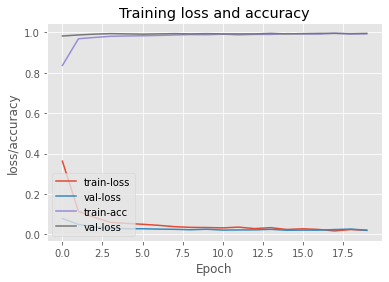

In [6]:
#plot

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,N), H.history["loss"], label=("train-loss"))
plt.plot(np.arange(0,N), H.history["val_loss"], label=("val-loss"))
plt.plot(np.arange(0,N), H.history["accuracy"], label=("train-acc"))
plt.plot(np.arange(0,N), H.history["val_accuracy"], label=("val-loss"))
plt.title("Training loss and accuracy")
plt.xlabel("Epoch")
plt.ylabel("loss/accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")
